<a href="https://colab.research.google.com/github/KKobuszewski/optimcut/blob/main/Notes_Cutting_stock_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cutting stock problem

### Imports

In [1]:
import numpy as np
np.random.seed(11)

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

plt.rcParams["figure.figsize"]=(8,4)
plt.rcParams["font.size"]=12

## Heuristic solution

https://scipbook.readthedocs.io/en/latest/bpp.html

In [4]:
def BinPackingExample():
    B = 9
    w = [2,3,4,5,6,7,8]
    q = [4,2,6,6,2,2,2]
    s=[]
    for j in range(len(w)):
        for i in range(q[j]):
            s.append(w[j])
    return s,B

def FFD(s, B):
    remain = [B]
    sol = [[]]
    for item in sorted(s, reverse=True):
        for j,free in enumerate(remain):
            if free >= item:
                remain[j] -= item
                sol[j].append(item)
                break
        else:
            sol.append([item])
            remain.append(B-item)
    return sol

In [8]:
for j, e in enumerate([B]):
  print(j,e)

0 9


In [5]:
s,B = BinPackingExample()
print(s)
print(B)

sol = FFD(s, B)
print(sol)


[2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 8, 8]
9
[[8], [8], [7, 2], [7, 2], [6, 3], [6, 3], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [2, 2]]


## Column generation method

https://towardsdatascience.com/column-generation-in-linear-programming-and-the-cutting-stock-problem-3c697caf4e2b


## Annealing method

### Functions

In [ ]:
def draw_(order, material_id, material_length):

  fig, ax = plt.subplots()
  ax.set_xlim([0, max( [material_id.max()+2,5] )])

  _,occ = np. unique(material_id, return_counts=True)
  #cmap = cm.get_cmap('viridis', int(material_length.max())+1)
  cmap = mpl.colormaps['viridis']
  norm = mpl.colors.Normalize(vmin=0, vmax=int(material_length.max())+1)

  for uid in np.unique(material_id):
    bottom=0
    order_id = order[material_id==uid]

    for (i,id_) in enumerate(order_id):
      p = ax.bar(uid+1, id_, bottom=bottom, color=cmap(norm(id_)), edgecolor='darkgrey')
      bottom += id_

    p = ax.bar(uid+1, material_length[uid], fill=False, edgecolor='black')

  plt.xlabel("Material ID")
  plt.ylabel("Material length")
  plt.show()


def cuts_to_material(order, material_length):
  material_id      = np.empty(order.size,dtype=np.int32)
  current_length   = 0.0
  current_material = 0

  for it,slice in enumerate(order):
    current_length += slice

    if (current_length > material_length[current_material]):
      current_length = slice
      current_material += 1

    material_id[it] = current_material

  return material_id


def material_leftovers(order, material_id, material_length):
  leftovers = np.zeros( np.max(material_id)+1 )
  for material in np.unique(material_id):
    leftovers[material] = material_length[material] -              \
                          np.sum( order[material_id == material] )
  return leftovers


def swap_order(order):
  n = order.size
  i = np.random.randint(n)
  j = np.random.randint(n)
  while ((i == j) or (order[i] == order[j])):
    j = np.random.randint(n)

  new_order = np.copy(order)
  new_order[i]  = order[j]
  new_order[j]  = order[i]

  return new_order


def cost_function(order,material_id, material_length):
  leftovers = material_leftovers(order, material_id, material_length)
  #n_materials = material_id.max()
  return leftovers.sum() #+ leftovers.mean()*n_materials

def acceptance_probability(order,material_id, new_order,new_material_id, material_length, temp=1.0):
  return np.exp( (cost_function(order,     material_id,     material_length) - \
                  cost_function(new_order, new_material_id, material_length)) / temp )


def step(order, material_id, material_length, temp=1.0, verbose=0):
  #new_order = order.copy()
  ap = 0.0
  while( (ap == 0.0) or (ap < np.random.rand()) ):
    new_order       = swap_order(order)
    new_material_id = cuts_to_material(new_order, material_length)
    ap = acceptance_probability(order,material_id, new_order,new_material_id, material_length, temp=temp)

  if (verbose > 0):
    print(new_order, new_material_id,
          cost_function(new_order, new_material_id, material_length))
  return new_order, new_material_id

### Example

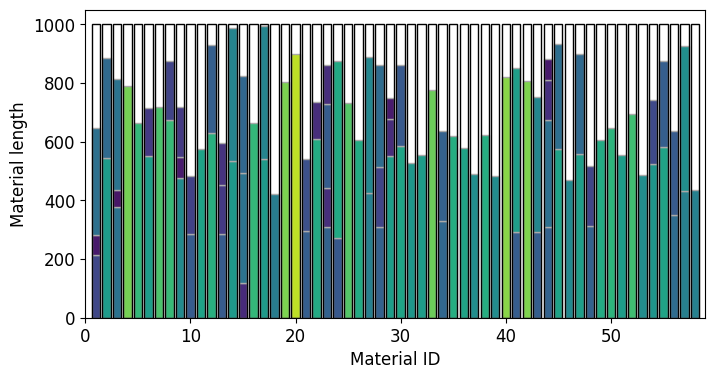

In [ ]:
#order           = np.array( [760,140,560,380,100,880,880]+6*[900] )
#order           = np.random.randint(1000, size=20)
order           = np.random.triangular(0, 250, 1000, 100)
material_id     = np.zeros_like(order,dtype=np.int32)
material_length = np.zeros_like(order)+1000; material_length[0] = 1000;


material_id = cuts_to_material(order,material_length)

#print(order)
#print(material_id)
#print(material_leftovers(order, material_id, material_length))
draw_(order, material_id, material_length)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-2-a3796af4c631>:71: RuntimeWarning: overflow encountered in exp
  return np.exp( (cost_function(order,     material_id,     material_length) - \
100%|██████████| 10000/10000 [00:44<00:00, 227.01it/s]


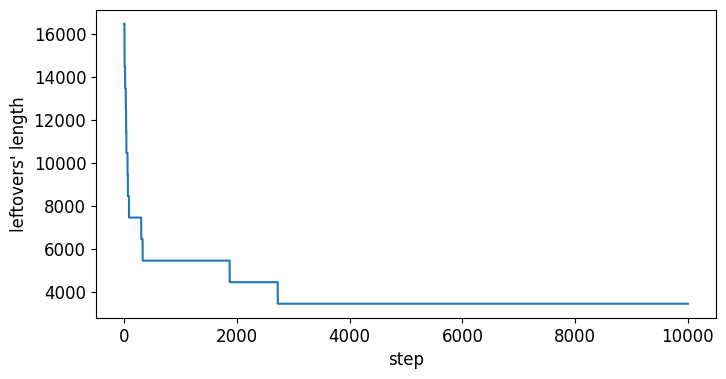

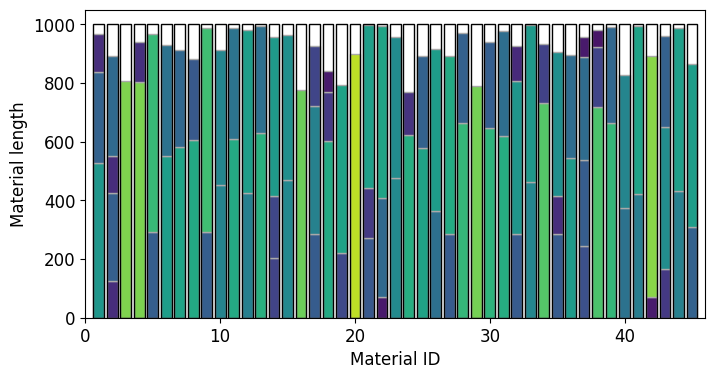

In [ ]:
nsteps = 10000
cost_func = np.empty(nsteps,dtype=np.float64)
for it in tqdm(range(nsteps)):
  order, material_id = step(order, material_id, material_length, temp=1.0, verbose=0)
  cost_func[it] = cost_function(order, material_id, material_length)

plt.xlabel(r'step')
plt.ylabel(r"leftovers' length")
plt.plot(cost_func)
plt.show()

draw_(order, material_id, material_length)

### Visualization

<ipython-input-22-b5bc0fffb9fd>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', order.max())


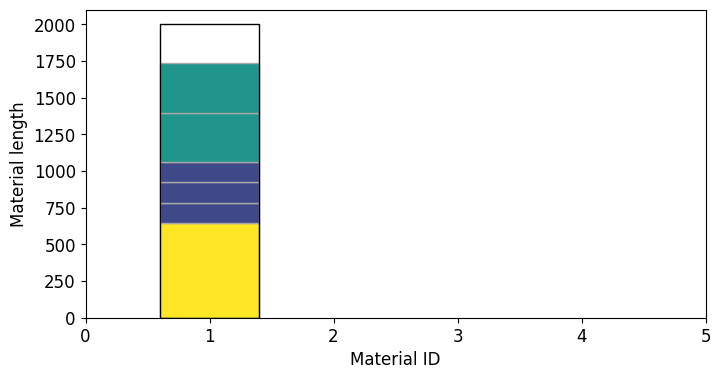

In [ ]:
order           = np.array( [644,140,140,140,335,335] )
material_id     = np.zeros_like(order)
material_length = np.zeros_like(order)+1000; material_length[0] = 2000;

draw_(order, material_id, material_length)

In [ ]:
type(order[0])

numpy.float64